In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
%matplotlib inline

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#definicao de funcoes que serao utilizadas
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

def score_evasao(y_true, y_pred): 
    tp = confusion_matrix(y_true, y_pred)[0, 0]
    fn = confusion_matrix(y_true, y_pred)[0, 1]
    
    return tp/(tp+fn)
   
#SELECIONANDO MELHOR MODEL RF
def make_RF(Xtrain, ytrain):
    #cria a randomforest 
    #forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 
    forest_clf = RandomForestClassifier(n_jobs=-1, random_state=0) 

    param_grid_forest = {'max_depth': [3, 5, None],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [10, 30, 100, 200],
                  'criterion': ["gini", "entropy"], 
                   #'class_weight': [{0:10, 1:.1}, 'balanced'] #foi utilizado quando os dados estavam desbalanceados
                    }
    
    #kappa_scorer = make_scorer(cohen_kappa_score)
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = kappa_scorer, cv=10)
    grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'accuracy', cv=10)
    
    grid_search_forest.fit(Xtrain, ytrain)
    print(grid_search_forest.best_params_)
    print(grid_search_forest.best_estimator_)
    
    #mostra os 3 melhores modelos
    report(grid_search_forest.cv_results_, 3)    
    
    return grid_search_forest.best_estimator_

def evaluating(model, ytest, ypred, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print("Cálculo de índices de avaliação:")
    
    print("Precisão: %f; Recall: %f, F1: %f" % (precision_score(ytest, ypred), 
                                                recall_score(ytest, ypred), 
                                                f1_score(ytest, ypred) ))

    #precisao
    print('Precisão CV:')
    scores = cross_val_score(model, Xtest, ytest, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))
    
def perfomance_compare(res_models):
    results = []
    names = []   
    
    #treina o modelo de acordo com os atributos selecionados
    for model in res_models:            
        results.append( model['cv_results'] )
        names.append(model['name'])
        msg = "Score do conjunto de testes: %f (%f) \n" % (model['cv_results'].mean(), model['cv_results'].std())
        print(msg)        

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot( results )
    ax.set_xticklabels( names )
    plt.xticks(rotation=90)
    plt.show()  
    
def feature_ranking(Xtest, model):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show()    

#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

def down_sample(dados):
    # Separate majority and minority classes
    df_majority = dados[dados.classe==1]
    df_minority = dados[dados.classe==0]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0],     # to match minority class
                                     random_state=0) # reproducible results

    # Combine majority class with upsampled minority class
    df_down = pd.concat([df_minority, df_majority_downsampled])

    # Display new class counts
    df_down.classe.value_counts()  
    
    return df_down

def up_sample(dados):
    # separa as classes majoritária e minoritária 
    df_majority = dados[dados.classe==1]
    df_minority = dados[dados.classe==0]

    # Upsample classe minoritária
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample com reposição
                                     n_samples=df_majority.shape[0],    # iguala a quantidade da classe majoritária
                                     random_state=0) 

    # junta as duas classes
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    print(df_upsampled.classe.value_counts()) 
    
    return df_upsampled

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import cohen_kappa_score

import numpy as np

def select_model(Xtrain, Xtest, ytrain, ytest):
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "DecisionTree",
            "estimator": DecisionTreeClassifier(),
            "hyperparameters":
                {
                    "criterion": ["gini", "entropy"],
                    #"min_samples_split": [2],
                    "max_depth": [None, 3, 5],
                    #"min_samples_leaf": [1],
                    "max_leaf_nodes": [None, 5, 10, 20]
                }
        },
        {
            "name": "Naive-Bayes",
            "estimator": GaussianNB(),
            "hyperparameters":
                {
                }
        },
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            #"estimator": RandomForestClassifier(n_jobs=-1, random_state=0),
            "estimator": RandomForestClassifier(n_jobs=-1),
            "hyperparameters":
                {
                    'max_depth': [3, 5, None],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'n_estimators': [10, 30, 100, 200],
                    'criterion': ["gini", "entropy"],                     
                }
        },
        {
            "name":"SVC",
            "estimator":SVC(),
            "hyperparameters":
                {
                  "kernel": ['rbf'],  
                  "C": [0.001, 0.01, 0.1, 1, 10],
                  "gamma": [0.001, 0.01, 0.1, 1]
                }
        },
        {
            # reference
            # https://github.com/UltravioletAnalytics/kaggle-titanic/blob/master/sgdclassifier.py
            "name":"SGDC",
            "estimator": SGDClassifier(),
            "hyperparameters":
            {
                "loss": ["log"],
                "alpha": [0.001],
                "penalty": ["elasticnet"],
                "l1_ratio": [0.8],
                "shuffle": [True],
                "learning_rate": ['optimal'],
                "max_iter":[1000]
            }
        }
    ]      
   
    results = []
    names = []    
     
    #score melhor apropriado para problema de classificação
    kappa_scorer = make_scorer(cohen_kappa_score)
        
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            scoring='accuracy')
        grid.fit(Xtrain, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
        
        #gerar o boxplot
        kfold = model_selection.KFold(n_splits=10, random_state=0)
        cv_results = model_selection.cross_val_score(model["best_model"], Xtest, ytest, cv=kfold, scoring='accuracy')
        model['cv_results'] = cv_results
        results.append(cv_results)
        names.append(model['name'])
        msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot( results )
    ax.set_xticklabels( names )
    plt.xticks(rotation=90)
    plt.show()
        
    return models



In [4]:
def select_model_tun(Xtrain, Xtest, ytrain, ytest, res_models):
    kappa_scorer = make_scorer(cohen_kappa_score)

    results = []
    names = []   
    
    #treina o modelo de acordo com os atributos selecionados
    for model in res_models:    
        if len(model['best_columns']) == 0:
            continue     

        Xtrain_2 = Xtrain[model['best_columns']]
        Xtest_2  = Xtest[model['best_columns']]


        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, 
                            scoring='accuracy')
        grid.fit(Xtrain_2, ytrain)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))

        #gerar o boxplot
        kfold = model_selection.KFold(n_splits=10, random_state=0)
        cv_results = model_selection.cross_val_score(model["best_model"], Xtest_2, ytest, cv=kfold, scoring='accuracy')
        model['cv_results'] = cv_results
        results.append(cv_results)
        names.append(model['name'])
        msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
        print(msg)        

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot( results )
    ax.set_xticklabels( names )
    plt.xticks(rotation=90)
    plt.show()
    
    return res_models

In [5]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')
dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Cenário 01

para cada algoritmo de ML será testado com todos os dados que não foram gerados de forma artificial e que não foram gerados após o aluno ter entrado no IF (nota, atendimento, frequência).

In [6]:
dados = dados_tunning.copy()

atributos = [
       'aluno_exclusivo_rede_publica', 'artificial', 'classe',
       'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

#down sample
dados = down_sample(dados)

print(dados.classe.value_counts())

1    349
0    349
Name: classe, dtype: int64


In [7]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)    

(698, 22)
(698, 22)
(698, 132)


DecisionTree
------------
Best Score: 0.5850860420650096
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10}
Score do conjunto de testes: 0.583007 (0.098172) 

Naive-Bayes
-----------
Best Score: 0.48565965583174
Best Parameters: {}
Score do conjunto de testes: 0.490850 (0.078224) 

LogisticRegression
------------------
Best Score: 0.5621414913957935
Best Parameters: {'solver': 'lbfgs'}
Score do conjunto de testes: 0.587908 (0.073648) 

KNeighborsClassifier
--------------------
Best Score: 0.5869980879541109
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
Score do conjunto de testes: 0.576797 (0.113754) 

RandomForestClassifier
----------------------
Best Score: 0.6080305927342257
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
Score do conjunto de testes: 0.548039 (0.095221) 

SVC
---
Best Score: 0.6061185468451242
Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


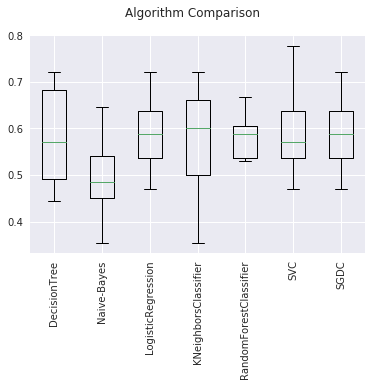

In [8]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

In [9]:
#seleciona os melhores atributos por modelo
for model in res_models:

    if model['name'] in ['Naive-Bayes', 'KNeighborsClassifier', 'SVC']:
        model['best_columns'] = []
        continue
    
    print(model['name'])
    print('-'*len(model['name']))
        
    #seleciona os melhores atributos para cada modelo
    selector = RFECV(model["best_model"], cv=10, n_jobs=-1)
    selector.fit(Xtest, ytest)

    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n{}\n".format(best_columns))    
    
    #salva os melhores atributos para o modelo
    model['best_columns'] = best_columns   
    
#print(res_models[0]['best_columns'])    
    

DecisionTree
------------
Best Columns 
['idade', 'qnt_pc', 'descricao_imovel_Próprio', 'sigla_CA', 'sigla_SC']

LogisticRegression
------------------
Best Columns 
['idade', 'possui_necessidade_especial', 'descricao_area_residencial_Rural', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_historico_Técnico de Nivel Médio em Agropecuária, na Forma Integrada', 'descricao_historico_Técnico de Nível Médio em Administração', 'descricao_historico_Técnico de Nível Médio em Eletrônica', 'descricao_historico_Técnico de Nível Médio em Logística', 'descricao_historico_Técnico de Nível Médio em Mecatrônica', 'descricao_historico_Técnico de Nível Médio em Multimídia', 'descricao_historico_Técnico de Nível Médio em Química', 'descricao_imovel_Cedido ou Emprestado', 'descricao_imovel_Não informado', 'descricao_imovel_Outro', 'descricao_mae_escolaridade_Ensino médio incompleto', 'descricao_pai_escolaridade_

DecisionTree
------------
Best Score: 0.5869980879541109
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': None}
Score do conjunto de testes: 0.622549 (0.140957) 

LogisticRegression
------------------
Best Score: 0.6022944550669216
Best Parameters: {'solver': 'liblinear'}
Score do conjunto de testes: 0.667974 (0.092273) 

RandomForestClassifier
----------------------
Best Score: 0.615678776290631
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}
Score do conjunto de testes: 0.577451 (0.108160) 

SGDC
----
Best Score: 0.5659655831739961
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}
Score do conjunto de testes: 0.662745 (0.063802) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


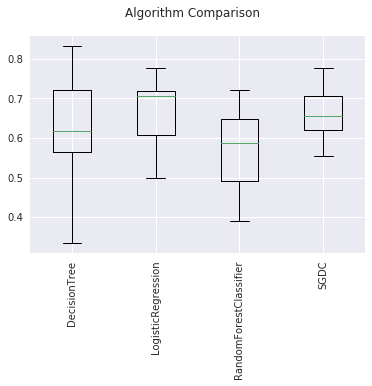

In [10]:
res_models_2 = select_model_tun(Xtrain, Xtest, ytrain, ytest, res_models)           

Score do conjunto de testes: 0.622549 (0.140957) 

Score do conjunto de testes: 0.490850 (0.078224) 

Score do conjunto de testes: 0.667974 (0.092273) 

Score do conjunto de testes: 0.576797 (0.113754) 

Score do conjunto de testes: 0.577451 (0.108160) 

Score do conjunto de testes: 0.592810 (0.095358) 

Score do conjunto de testes: 0.662745 (0.063802) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


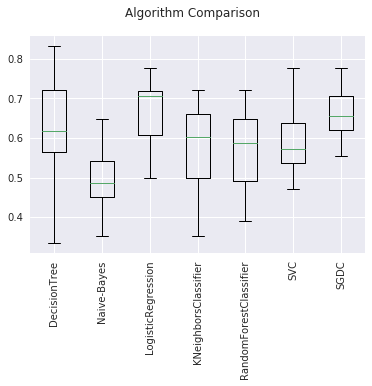

In [11]:
perfomance_compare(res_models_2)



DecisionTree
------------
Valor de falso positivo:0.3181818181818182
Cálculo de índices de avaliação:
Precisão: 0.650000; Recall: 0.597701, F1: 0.622754
Precisão CV:
[0.66666667 0.77777778 0.66666667 0.72222222 0.72222222 0.5
 0.66666667 0.58823529 0.75       0.4375    ]
0.649795751633987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


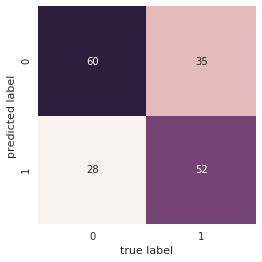

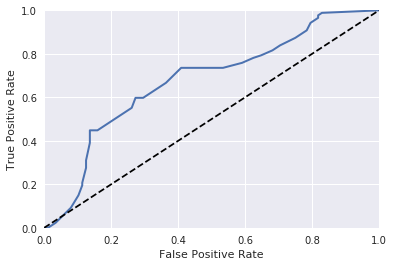

0.6776384535005224


Naive-Bayes
-----------
Valor de falso positivo:0.9090909090909091
Cálculo de índices de avaliação:
Precisão: 0.506173; Recall: 0.942529, F1: 0.658635
Precisão CV:
[0.33333333 0.72222222 0.44444444 0.5        0.38888889 0.5
 0.66666667 0.41176471 0.375      0.5       ]
0.48423202614379085


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


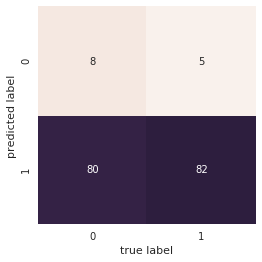

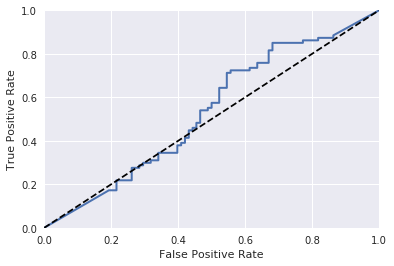

0.5348092998955067


LogisticRegression
------------------
Valor de falso positivo:0.4431818181818182
Cálculo de índices de avaliação:
Precisão: 0.593750; Recall: 0.655172, F1: 0.622951
Precisão CV:
[0.66666667 0.77777778 0.66666667 0.61111111 0.61111111 0.55555556
 0.66666667 0.52941176 0.75       0.6875    ]
0.6522467320261438


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


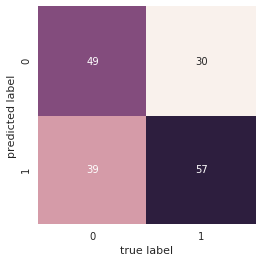

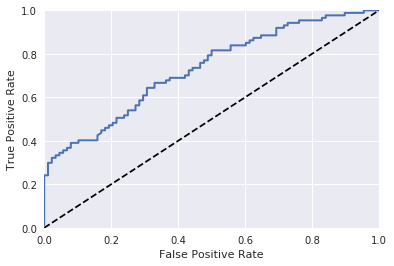

0.7296891327063739


KNeighborsClassifier
--------------------
Valor de falso positivo:0.6136363636363636
Cálculo de índices de avaliação:
Precisão: 0.546218; Recall: 0.747126, F1: 0.631068
Precisão CV:
[0.55555556 0.77777778 0.55555556 0.66666667 0.61111111 0.55555556
 0.55555556 0.64705882 0.75       0.25      ]
0.592483660130719


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


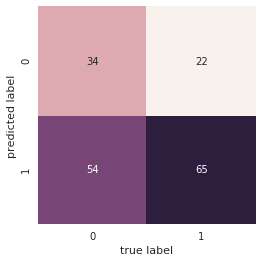

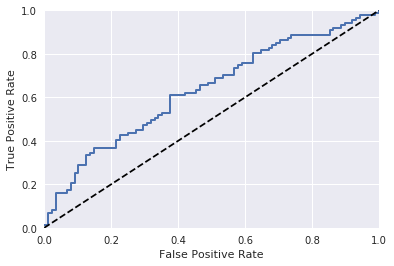

0.6328369905956114


RandomForestClassifier
----------------------
Valor de falso positivo:0.5227272727272727
Cálculo de índices de avaliação:
Precisão: 0.574074; Recall: 0.712644, F1: 0.635897
Precisão CV:
[0.72222222 0.72222222 0.5        0.61111111 0.55555556 0.61111111
 0.66666667 0.47058824 0.6875     0.5625    ]
0.6109477124183006


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


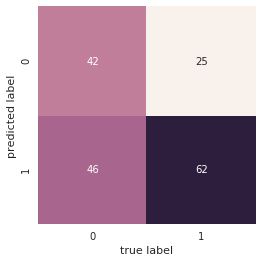

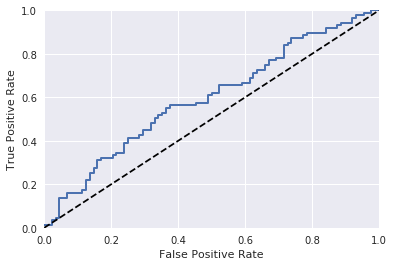

0.5949582027168234


SGDC
----
Valor de falso positivo:0.375
Cálculo de índices de avaliação:
Precisão: 0.652632; Recall: 0.712644, F1: 0.681319
Precisão CV:
[0.44444444 0.88888889 0.72222222 0.61111111 0.55555556 0.61111111
 0.66666667 0.58823529 0.625      0.625     ]
0.6338235294117648


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


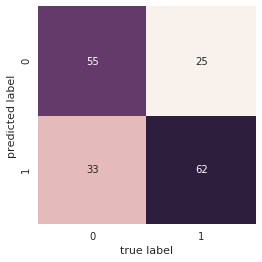

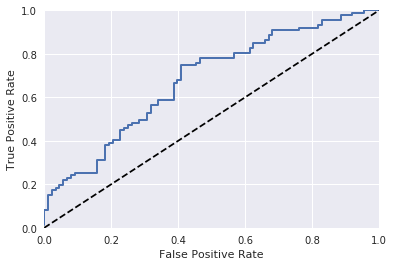

0.6765935214211076


In [12]:
#avaliacao individual por modelo
for model in res_models:        
    if model['name'] in ['SVC']:
        continue
    
    print('\n\n'+model['name'])
    print('-'*len(model['name']))
    
    Xtest_2  = Xtest
    
    if len(model['best_columns']):
        Xtest_2  = Xtest[model['best_columns']]

    ypred = model['best_model'].predict(Xtest_2)

    evaluating(model['best_model'], ytest, ypred, Xtest_2)

# Cenário 02: utilizando todos os atributos

In [13]:
dados = dados_tunning.copy()

atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#recupera apenas os dados que nao foram criados de forma artificial
dados = dados[dados.artificial == 0]

#down sample
dados = down_sample(dados)

print(dados.classe.value_counts())

1    349
0    349
Name: classe, dtype: int64


In [14]:
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)   

(698, 31)
(698, 31)
(698, 146)


DecisionTree
------------
Best Score: 0.858508604206501
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10}
Score do conjunto de testes: 0.845752 (0.068857) 

Naive-Bayes
-----------
Best Score: 0.6634799235181644
Best Parameters: {}
Score do conjunto de testes: 0.627451 (0.091562) 

LogisticRegression
------------------
Best Score: 0.858508604206501
Best Parameters: {'solver': 'liblinear'}
Score do conjunto de testes: 0.824183 (0.070528) 

KNeighborsClassifier
--------------------
Best Score: 0.8336520076481836
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Score do conjunto de testes: 0.805556 (0.045288) 

RandomForestClassifier
----------------------
Best Score: 0.8680688336520076
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 30}
Score do conjunto de testes: 0.891503 (0.054562) 

SVC
---
Best Score: 0.8279158699808795
Best Parameters: {'C': 0.1, 'gamma': 0.001, 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


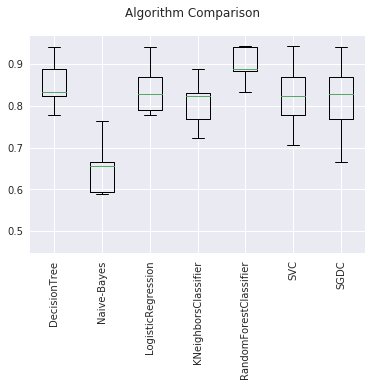

In [15]:
res_models = select_model(Xtrain, Xtest, ytrain, ytest)

In [16]:
#seleciona os melhores atributos por modelo
for model in res_models:

    if model['name'] in ['Naive-Bayes', 'KNeighborsClassifier', 'SVC']:
        model['best_columns'] = []
        continue
    
    print(model['name'])
    print('-'*len(model['name']))
        
    #seleciona os melhores atributos para cada modelo
    selector = RFECV(model["best_model"], cv=10, n_jobs=-1)
    selector.fit(Xtest, ytest)

    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n{}\n".format(best_columns))    
    
    #salva os melhores atributos para o modelo
    model['best_columns'] = best_columns   

DecisionTree
------------
Best Columns 
['conceito_I', 'conceito_R']

LogisticRegression
------------------
Best Columns 
['conceito_I', 'conceito_O', 'conceito_R', 'conceito_freq_R', 'descricao_area_residencial_Urbana', 'descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros', 'descricao_imovel_Não informado', 'descricao_responsavel_financeiro_Cônjuge', 'sigla_CA']

RandomForestClassifier
----------------------
Best Columns 
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'artificial', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_S', 'conceito_freq_R', 'conceito_freq_S', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_c

DecisionTree
------------
Best Score: 0.8776290630975143
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None}
Score do conjunto de testes: 0.890850 (0.076336) 

LogisticRegression
------------------
Best Score: 0.8776290630975143
Best Parameters: {'solver': 'newton-cg'}
Score do conjunto de testes: 0.890850 (0.076336) 

RandomForestClassifier
----------------------
Best Score: 0.864244741873805
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}
Score do conjunto de testes: 0.872876 (0.078206) 

SGDC
----
Best Score: 0.8298279158699808
Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.8, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'shuffle': True}
Score do conjunto de testes: 0.835621 (0.087140) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


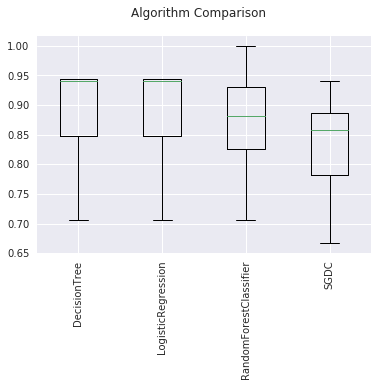

In [17]:
res_models_2 = select_model_tun(Xtrain, Xtest, ytrain, ytest, res_models)           

Score do conjunto de testes: 0.890850 (0.076336) 

Score do conjunto de testes: 0.627451 (0.091562) 

Score do conjunto de testes: 0.890850 (0.076336) 

Score do conjunto de testes: 0.805556 (0.045288) 

Score do conjunto de testes: 0.872876 (0.078206) 

Score do conjunto de testes: 0.822222 (0.066271) 

Score do conjunto de testes: 0.835621 (0.087140) 



/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


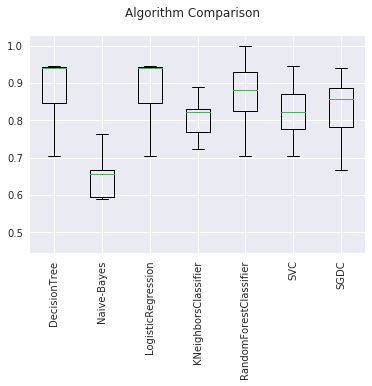

In [18]:
perfomance_compare(res_models_2)



DecisionTree
------------
Valor de falso positivo:0.056818181818181816
Cálculo de índices de avaliação:
Precisão: 0.935897; Recall: 0.839080, F1: 0.884848
Precisão CV:
[0.94444444 0.83333333 0.88888889 0.94444444 0.83333333 0.83333333
 0.88888889 0.88235294 0.9375     0.9375    ]
0.8924019607843137


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


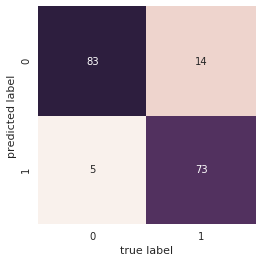

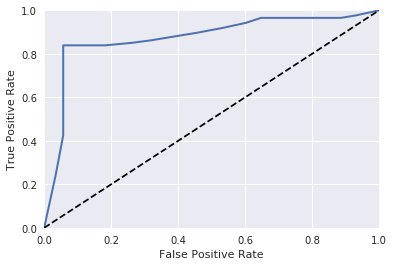

0.8733672936259144


Naive-Bayes
-----------
Valor de falso positivo:0.4772727272727273
Cálculo de índices de avaliação:
Precisão: 0.655738; Recall: 0.919540, F1: 0.765550
Precisão CV:
[0.66666667 0.83333333 0.66666667 0.72222222 0.61111111 0.5
 0.83333333 0.52941176 0.5        0.8125    ]
0.6675245098039216


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


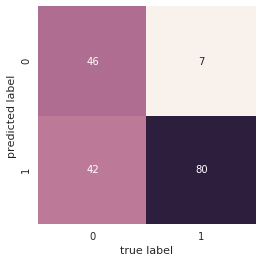

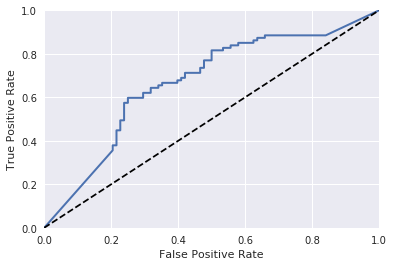

0.6703239289446186


LogisticRegression
------------------
Valor de falso positivo:0.056818181818181816
Cálculo de índices de avaliação:
Precisão: 0.935897; Recall: 0.839080, F1: 0.884848
Precisão CV:
[0.94444444 0.83333333 0.88888889 0.94444444 0.83333333 0.83333333
 0.88888889 0.88235294 0.9375     0.9375    ]
0.8924019607843137


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


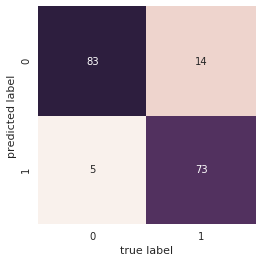

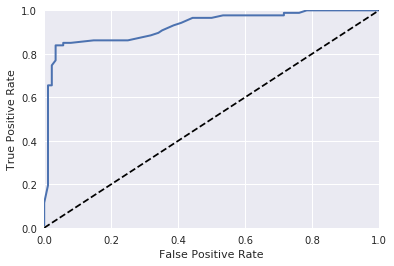

0.9270506792058516


KNeighborsClassifier
--------------------
Valor de falso positivo:0.26136363636363635
Cálculo de índices de avaliação:
Precisão: 0.772277; Recall: 0.896552, F1: 0.829787
Precisão CV:
[0.83333333 0.88888889 0.83333333 0.88888889 0.66666667 0.77777778
 0.88888889 0.76470588 0.75       0.8125    ]
0.8104983660130719


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


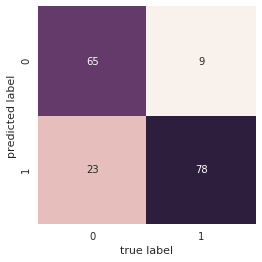

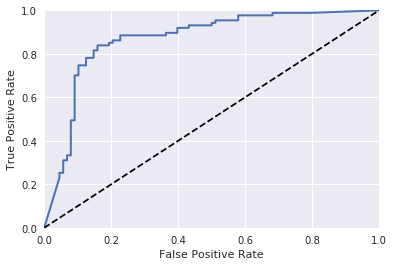

0.8683385579937304


RandomForestClassifier
----------------------
Valor de falso positivo:0.10227272727272728
Cálculo de índices de avaliação:
Precisão: 0.891566; Recall: 0.850575, F1: 0.870588
Precisão CV:
[0.88888889 0.94444444 0.88888889 0.94444444 0.83333333 0.83333333
 0.88888889 0.82352941 0.875      0.875     ]
0.8795751633986928


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


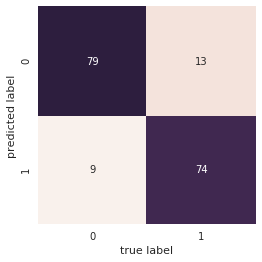

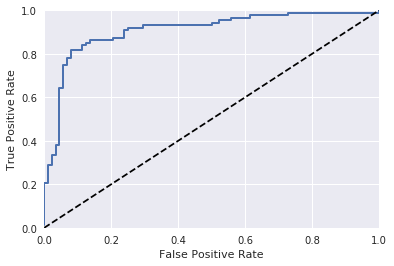

0.9059561128526645


SGDC
----
Valor de falso positivo:0.13636363636363635
Cálculo de índices de avaliação:
Precisão: 0.855422; Recall: 0.816092, F1: 0.835294
Precisão CV:
[0.77777778 0.83333333 0.77777778 0.83333333 0.83333333 0.77777778
 0.83333333 0.88235294 0.875      0.8125    ]
0.8236519607843137


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


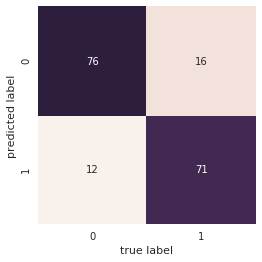

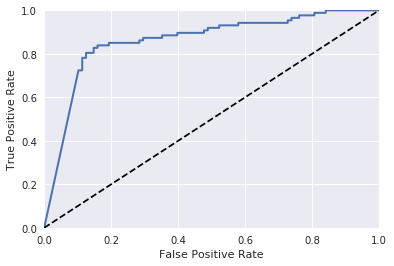

0.8625261233019854


In [19]:
#avaliacao individual por modelo
for model in res_models:        
    if model['name'] in ['SVC']:
        continue
    
    print('\n\n'+model['name'])
    print('-'*len(model['name']))
    
    Xtest_2  = Xtest
    
    if len(model['best_columns']):
        Xtest_2  = Xtest[model['best_columns']]

    ypred = model['best_model'].predict(Xtest_2)

    evaluating(model['best_model'], ytest, ypred, Xtest_2)

In [20]:
#FIM